# Accumulated Local Effects (ALE) Plots Demonstration

This notebook demonstrates how to compute and interpret ALE and visualizations using scikit-learn. ALE is a measure of local effects and global interpretability that is robust to correlated features. 

We'll use the Ames Housing dataset and a Gradient boosting Regression model.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.datasets import fetch_openml

## Load and Explore the Data

In [2]:
# Ames housing dataset from openml
data = fetch_openml(name="house_prices", as_frame=True)
df = data.frame

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
#Drop columns with too many missing values or that aren't relevant
bad_columns = ["Id", "Alley", "PoolQC", "Fence", "MiscFeature", "FireplaceQu"]
df = df.drop(columns = bad_columns)

In [5]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

## Data Preprocessing

In [6]:
# Separate numerical and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

# Preprocessing by type
# fill in missing numerical values with the median
num_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
# fill in missing categorical values with the mode
cat_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

In [7]:
# Train_test_split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Define and Train the Model

In [8]:
model = make_pipeline(preprocessor, GradientBoostingRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stF...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

## Visualize Feature Effects with ALE plot

### Create an ALE Plotting Function

In [9]:
def plot_ale(model, X_raw, feature, bins=50, ax=None):
    """
    Compute and plot a 1D Accumulated Local Effects (ALE) plot
    Parameters:
        model: pretrained pipeline model
        X_raw: raw input dataframe (untransformed)
        feature: feature name (str)
        bins: number of intervals to compute local effects
        ax: matplotlib axes to plot on (optional)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    X_copy = X_raw.copy()
    x_vals = X_copy[feature]
    quantiles = np.quantile(x_vals, np.linspace(0, 1, bins+1))
    ale_values = []

    for i in range(bins):
        lower, upper = quantiles[i], quantiles[i+1]
        mask = (x_vals >= lower) & (x_vals < upper)
        if not mask.any():
            ale_values.append(0)
            continue

        X_lower = X_copy.copy()
        X_upper = X_copy.copy()

        #set dtype to accept float values
        X_lower[feature] = X_lower[feature].astype(float)
        X_upper[feature] = X_upper[feature].astype(float)
        
        X_lower.loc[mask, feature] = lower
        X_upper.loc[mask, feature] = upper

        preds_lower = model.predict(X_lower)
        preds_upper = model.predict(X_upper)
        diffs = preds_upper[mask] - preds_lower[mask]
        ale_values.append(np.mean(diffs))

    # accumulate and center
    accumulated = np.cumsum(ale_values)
    accumulated -= np.mean(accumulated)
    mid_points = 0.5 * (quantiles[:-1] + quantiles[1:])

    ax.plot(mid_points, accumulated, label=f"ALE of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Accumulated Local Effect")
    ax.set_title(f"ALE Plot for {feature}")
    ax.grid(True)

    return ax

### Visualize ALE for Selected Features

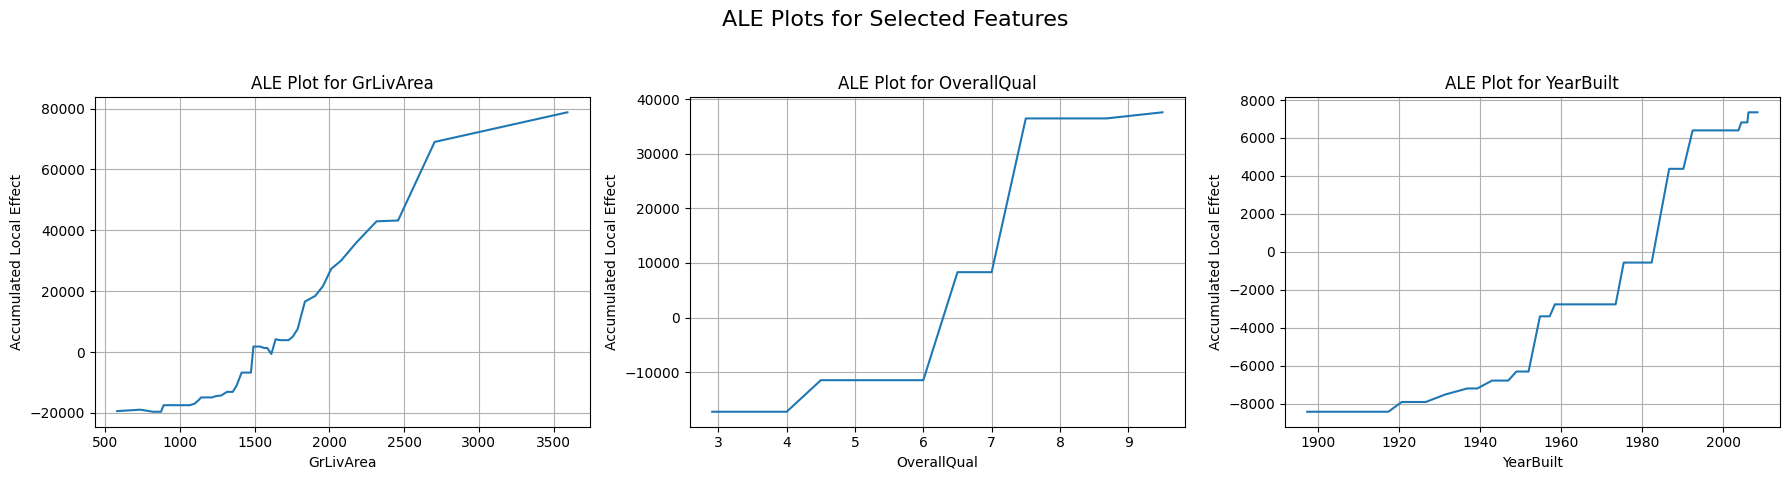

In [10]:
# features to plot
example_features = ["GrLivArea", "OverallQual", "YearBuilt"]

# Plot ale side-by-side
fig, axes = plt.subplots(1, len(example_features), figsize = (18,5))

for i, feature in enumerate(example_features):
    plot_ale(model, X_test, feature, ax=axes[i])

fig.suptitle("ALE Plots for Selected Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Compare ALE Plots to PDPs

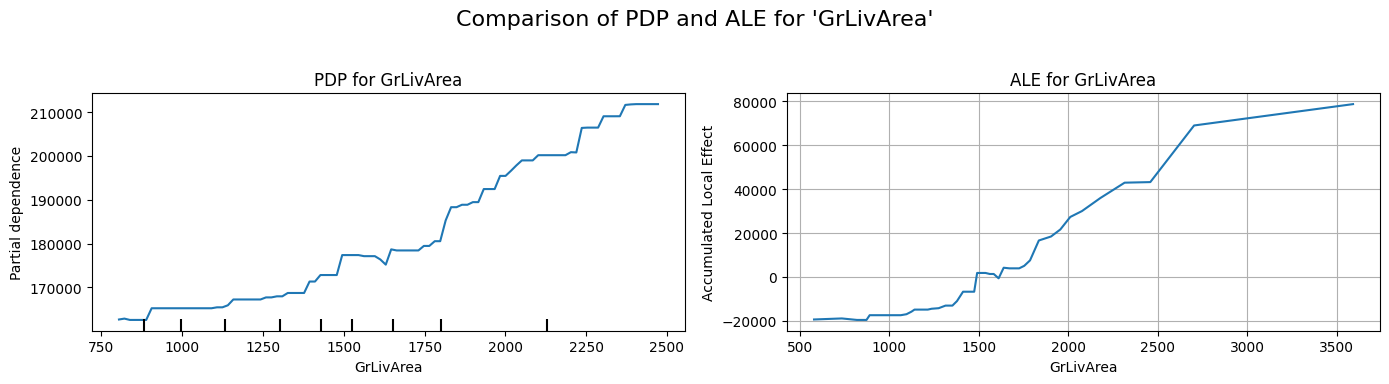

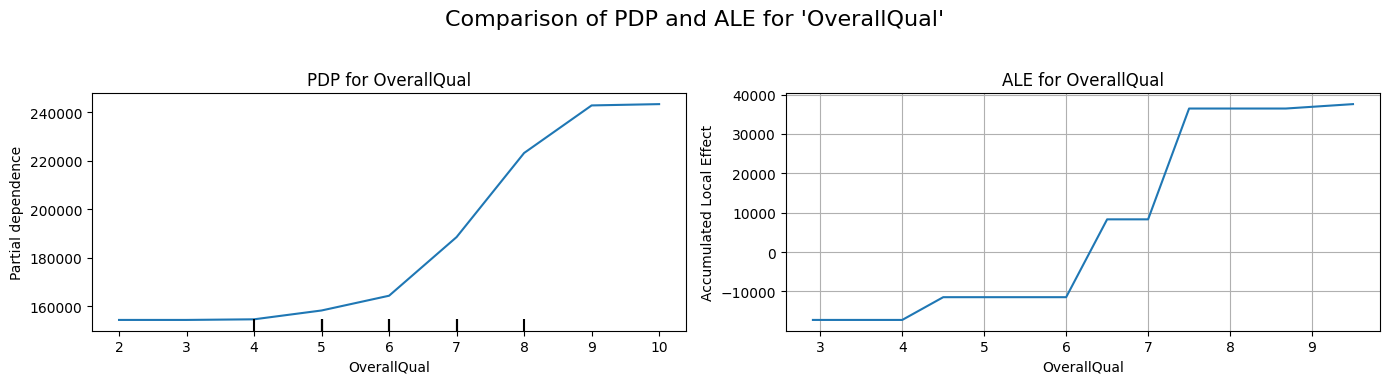

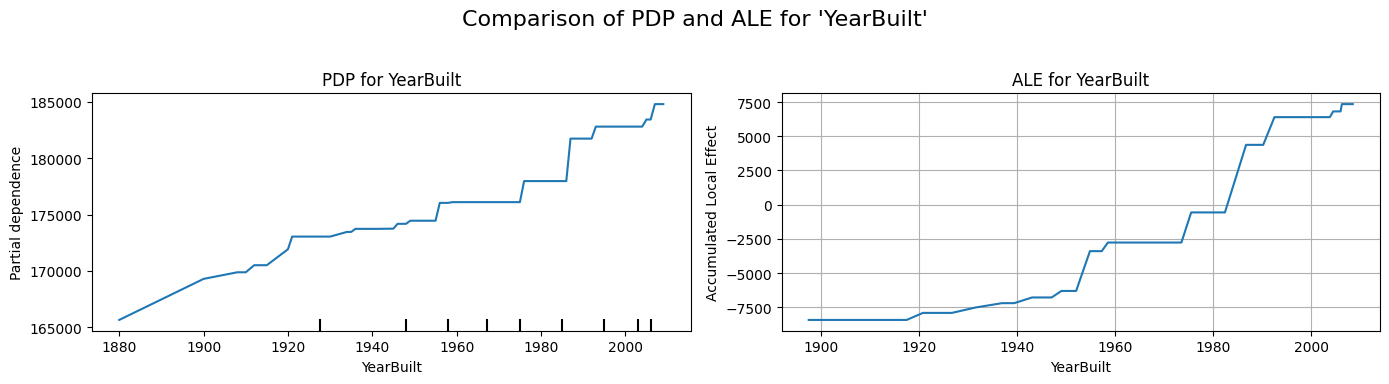

In [11]:
for feature in example_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # PDP
    PartialDependenceDisplay.from_estimator(
        model,
        X_test,
        features=[feature],
        ax=axes[0],
        kind="average"
    )
    axes[0].set_title(f"PDP for {feature}")

    # ALE
    plot_ale(model, X_test, feature, ax=axes[1])
    axes[1].set_title(f"ALE for {feature}")

    fig.suptitle(f"Comparison of PDP and ALE for '{feature}'", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### ALE vs. PDP Interpretation

Although the ALE and PDPs look very similar, there are some differences that can be telling and quite relevant depending on your needs. For each of the features plotted above, the ALE and PDPs capture the global trends, but only ALE honors local effects, is good for feature thresholding, and can handle correlated features. 

ALE vs PDP for Living Area:
- Both methods agree that larger homes sell for more
- ALE, however, shows **where** the model is learning those gains most clearly (~1200-2000 sq ft) and avoids extrapolating in low-data regions (<1000 or >3000 sq ft)
- ALE shows better respect for data density and feature correlation

ALE vs PDP for Overall Material Quality:
- Both methods agree on the importance of quality
- ALE offers better resolution on where in the rating scale the big jumps occur, and how strong those jumps are (between ratings of 6 and 8)
- ALE reveals that after a rating of 8, there is no extra benefit to home price for increasing material quality - something not clear in the PDP, and that could be useful for pricing and renovation strategy

ALE vs PDP for Year Built:
- PDP shows a smooth clear global trend, but may overstate the importance of year across the entire range without the granularity of ALE
- ALE makes it clear that the model only cares about "age" in certain eras, such as post-WWII or modern builds
- The ALE plot supports the idea that historical construction practices or retrofits create natural segmentation not captured by PDP.